In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [21]:
warnings.filterwarnings('ignore')
data = pd.read_csv('covtype.csv')

In [22]:
x = data.loc[:, 'Elevation' : 'Soil_Type40']
y = data.loc[:, 'Cover_Type']

In [23]:
# Features to remove from the dataset
features_to_remove = ['Hillshade_3pm', 'Vertical_Distance_To_Hidrology','Soil_Type7','Soil_Type8',
                     'Soil_Type14','Soil_Type15','Soil_Type21',
                     'Soil_Type25','Soil_Type28','Soil_Type36','Soil_Type37']
x.drop(features_to_remove, axis=1, inplace=True)

In [24]:
x.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,6279,1,...,1,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,6225,1,...,1,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,6121,1,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,6211,1,...,0,1,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,6172,1,...,1,0,0,0,0,0,0,0,0,0


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [38]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=0)
print(len(x_over))

861566


In [26]:
# Train-test approach
def train_test_classify(classifier):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    evaluate_metrics(y_test, y_pred)

In [27]:
# Cross-validation approach
def cross_validate(classifier, x, y):
    x = np.array(x)
    y = np.array(y)
    kf = KFold(n_splits=10)
    kf.get_n_splits(x)
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        print('Fold {}:'.format(i))
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        evaluate_metrics(y_test, y_pred)    

In [28]:
# Evaluation metrics
def evaluate_metrics(y_test, y_pred):
    print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Precision: {}'.format(metrics.precision_score(y_test, y_pred.round(), average="macro")))
    print('Recall: {}'.format(metrics.recall_score(y_test, y_pred.round(), average="macro")))
    print('F1-score: {}'.format(metrics.f1_score(y_test, y_pred.round(), average="macro")))
    print('Kappa score: {}'.format(metrics.cohen_kappa_score(y_test, y_pred)))

In [29]:
def plot_learning_curve(classifier, img_name):
    train_sizes, train_scores, test_scores = learning_curve(
    estimator=classifier, 
    X=x_train, y=y_train, 
    train_sizes=np.linspace(0.1,1,10), 
    cv=10, n_jobs=-1)

    print(train_scores)
    print(test_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='green', marker='o',
             markersize=5,label ='Training accuracy')

    plt.plot(train_sizes, test_mean, 
             color='purple', linestyle='--',
             marker='s', markersize=5, 
             label='Validation accuracy')

    plt.grid()
    plt.xlabel('Training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.25, 1.01])
    plt.tight_layout()
    plt.savefig(img_name + '-mean.png', dpi=300)
    plt.show()

In [30]:
def plot_confusion_matrix(classifier):
    class_names = [1,2,3,4,5,6,7]
    disp = metrics.plot_confusion_matrix(classifier, x_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Greens)
    disp.ax_.set_title('Confusion matrix, without normalization')
    plt.tight_layout()
    plt.savefig(classifier.__class__.__name__ + '-ConfusionMatrix.png', dpi=300)
    plt.show()

    disp = metrics.plot_confusion_matrix(classifier, x_test, y_test,
                                         display_labels=class_names,
                                         cmap=plt.cm.Greens,
                                         normalize='true')
    disp.ax_.set_title('Normalized confusion matrix')
    plt.tight_layout()
    plt.savefig(classifier.__class__.__name__ + '-ConfusionMatrix-normalized.png', dpi=300)
    plt.show()


In [37]:
%%time
rf_hyperparameters = {
    'n_estimators': 100,
    'max_depth': 23,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'bootstrap': False,
    'n_jobs': -1
}
rf = RandomForestClassifier()
rf.set_params(**rf_hyperparameters)
train_test_classify(rf)

Accuracy: 0.9553779727706396
Precision: 0.9563911530198687
Recall: 0.8863910542260623
F1-score: 0.9149775796591515
Kappa score: 0.9377838344501516
Wall time: 1min 2s


In [36]:
%%time
dt = DecisionTreeClassifier(max_depth=22)
train_test_classify(dt)

Accuracy: 0.9428659308007474
Precision: 0.9144035482443719
Recall: 0.8720787552038843
F1-score: 0.891147777826097
Kappa score: 0.9204497250601106
Wall time: 9.1 s


In [35]:
%%time
nb = GaussianNB()
train_test_classify(nb)

Accuracy: 0.61133163875251
Precision: 0.4861816084877653
Recall: 0.5744513520098915
F1-score: 0.4331559927898075
Kappa score: 0.49454675746450416
Wall time: 1.43 s


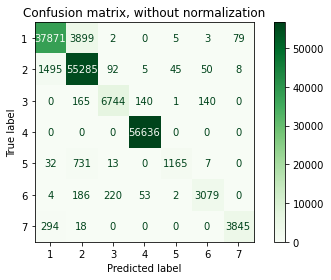

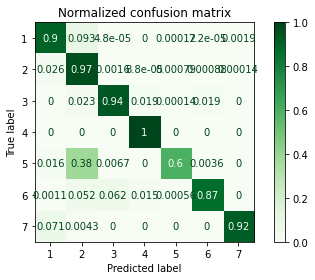

In [39]:
plot_confusion_matrix(rf)

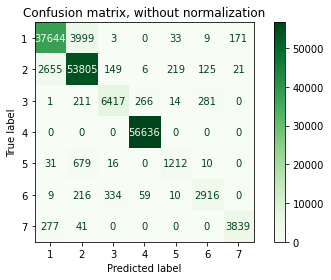

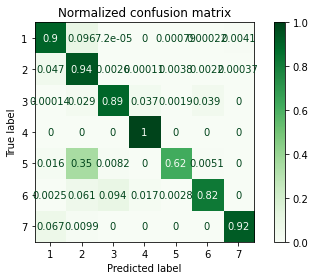

In [40]:
plot_confusion_matrix(dt)

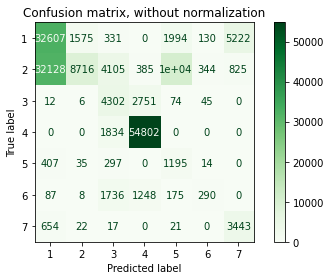

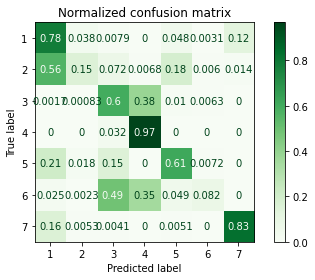

In [41]:
plot_confusion_matrix(nb)

In [74]:
cross_validate(rf, x_train, y_train)

Fold 0:
Accuracy: 0.9282717669585422
Precision: 0.9403675710087834
Recall: 0.8674602415135059
F1-score: 0.8975084888594536
Kappa score: 0.8834234766026308
Fold 1:
Accuracy: 0.927110001936275
Precision: 0.94235599280437
Recall: 0.8634010970609
F1-score: 0.895545935250131
Kappa score: 0.8815872448394526
Fold 2:
Accuracy: 0.9265291194251415
Precision: 0.9405868988944072
Recall: 0.8568816249872976
F1-score: 0.8906379032426534
Kappa score: 0.8806924380765245
Fold 3:
Accuracy: 0.9279490544523569
Precision: 0.9436981141781918
Recall: 0.8646399658022995
F1-score: 0.8960896546182092
Kappa score: 0.8826819602782375
Fold 4:
Accuracy: 0.9278414836169617
Precision: 0.9468552389010954
Recall: 0.8553401509325159
F1-score: 0.8924022770320771
Kappa score: 0.8831513616069895
Fold 5:
Accuracy: 0.9293689894795722
Precision: 0.9404650017263056
Recall: 0.8662959084146606
F1-score: 0.8955335810660792
Kappa score: 0.8853988029261728
Fold 6:
Accuracy: 0.9283363094597793
Precision: 0.9456543779762429
Recall: 0.

In [75]:
cross_validate(dt, x_train, y_train)

Fold 0:
Accuracy: 0.9174071125836363
Precision: 0.8878164023881906
Recall: 0.863116705728167
F1-score: 0.8742304329583079
Kappa score: 0.8665997122024149
Fold 1:
Accuracy: 0.9167832017383447
Precision: 0.8901151159791791
Recall: 0.8499417843455753
F1-score: 0.8676101024718923
Kappa score: 0.8656186719647387
Fold 2:
Accuracy: 0.9183107076009552
Precision: 0.8888047443993218
Recall: 0.8406868917168481
F1-score: 0.8609140775311878
Kappa score: 0.86807585336946
Fold 3:
Accuracy: 0.9186549342742196
Precision: 0.8828936932542516
Recall: 0.8460212859590145
F1-score: 0.8626794582708064
Kappa score: 0.868468172275274
Fold 4:
Accuracy: 0.9167832017383447
Precision: 0.8852373151811231
Recall: 0.8454797080231021
F1-score: 0.8637539350771247
Kappa score: 0.866022434030977
Fold 5:
Accuracy: 0.9166971450700286
Precision: 0.8784923788296439
Recall: 0.8574732337305937
F1-score: 0.8671270961210611
Kappa score: 0.8658223820728672
Fold 6:
Accuracy: 0.9187409909425357
Precision: 0.8874898052504481
Recall: 

In [76]:
cross_validate(nb, x_train, y_train)

Fold 0:
Accuracy: 0.4547664637163572
Precision: 0.3957165178925713
Recall: 0.5963225176983656
F1-score: 0.3625049898371869
Kappa score: 0.25695550591589067
Fold 1:
Accuracy: 0.4564445687485209
Precision: 0.3882513140283851
Recall: 0.5859708107566621
F1-score: 0.36249838681922225
Kappa score: 0.25890107673633533
Fold 2:
Accuracy: 0.46059680299477207
Precision: 0.39056301674939153
Recall: 0.5924418091825555
F1-score: 0.36433386587137956
Kappa score: 0.2627956283394738
Fold 3:
Accuracy: 0.4559712570727824
Precision: 0.39308401884309047
Recall: 0.5869519323380558
F1-score: 0.3598349151052164
Kappa score: 0.25796258376866854
Fold 4:
Accuracy: 0.45661668208515305
Precision: 0.39553229118235095
Recall: 0.586600209789136
F1-score: 0.3643977751807177
Kappa score: 0.2597252937017246
Fold 5:
Accuracy: 0.4568748520901013
Precision: 0.38855158952715874
Recall: 0.58422077757737
F1-score: 0.35663749622577157
Kappa score: 0.2592714132352647
Fold 6:
Accuracy: 0.45317441535250963
Precision: 0.3863703299

[[0.98917097 0.98991203 0.98711513 0.98835819 0.98986422 0.98986422
  0.99103557 0.98991203 0.98972079 0.98964907]
 [0.98234626 0.98127054 0.98641009 0.98345784 0.98454551 0.98459332
  0.98355346 0.9834937  0.9837447  0.98110321]
 [0.98058933 0.97784028 0.98136225 0.98096384 0.98097181 0.98180051
  0.98219095 0.98342603 0.98090009 0.98176067]
 [0.97733235 0.97754152 0.97968099 0.97801364 0.98046985 0.97809133
  0.97736223 0.97537814 0.98074475 0.97830647]
 [0.97990572 0.97885391 0.97690807 0.97384349 0.97799334 0.97713278
  0.97875351 0.97524431 0.97886826 0.97502916]
 [0.97590001 0.97825065 0.97690401 0.97480438 0.97835822 0.97526255
  0.97481235 0.97497968 0.97360914 0.97554144]
 [0.97189486 0.9770173  0.97798032 0.97488637 0.97306961 0.97465415
  0.97489661 0.97389603 0.97486246 0.97324036]
 [0.9712486  0.974661   0.97335819 0.97133825 0.97354644 0.97319385
  0.97351357 0.97010715 0.97216595 0.97259922]
 [0.97181636 0.97562783 0.9724246  0.9729691  0.96953744 0.97268755
  0.97213243

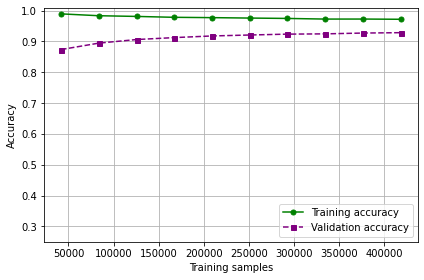

In [88]:
plot_learning_curve(rf, 'RandomForest')

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0.89085863 0.89154708 0.89159011 0.89232159 0.89019169 0.89107377
  0.89178374 0.89253674 0.89034229 0.89262048]
 [0.91772983 0.91998881 0.91887008 0.91772983 0.91770831 0.91805254
  0.9189131  0.91925733 0.91833222 0.91843804]
 [0.93070287 0.93143435 0.93309094 0.93246703 0.93134829 0.93093952
  0.93392999 0.93175706 0.93007896 0.93287435]
 [0.94042727 0.94068544 0.94051333 0.93965276 0.93928702 0.94053484
  0.94283686 0.94143844 0.93836191 0.94072719]
 [0.94716121 0.94632215 0.94744089 0.94703212 0.94544007 0.94589187
  0.9480648  0.94701061 0.94604247 0.94688038]
 [0.95122738 0.95213098 0.95135647 0.95195886 0.94982896 0.95096921
  0.95348637 0.95210946 0.

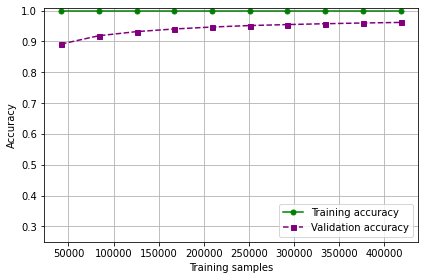

In [89]:
# Executes the Random Forest classifier without setting any max depth, to highlight overfitting
rf_hyperparameters = {
    'n_estimators': 100,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'bootstrap': False,
    'n_jobs': -1
}
rf = RandomForestClassifier()
rf.set_params(**rf_hyperparameters)
plot_learning_curve(rf, 'RandomForest-no_max_depth')

[[0.98058902 0.9758319  0.9758558  0.97587971 0.97578409 0.97587971
  0.97576018 0.97580799 0.9758558  0.9758558 ]
 [0.97401542 0.97042969 0.97068069 0.97063288 0.97062093 0.97064483
  0.97063288 0.97065679 0.97064483 0.97062093]
 [0.97606336 0.96995968 0.97087603 0.96812698 0.96812698 0.96811105
  0.96809511 0.96811105 0.9681987  0.96813495]
 [0.97295181 0.96852944 0.97204941 0.97051951 0.97139203 0.9713502
  0.97139801 0.9713741  0.97133227 0.97140398]
 [0.96919164 0.9669446  0.96720755 0.9684984  0.9735662  0.97079803
  0.97075501 0.97078847 0.97082672 0.97081238]
 [0.96802339 0.96374843 0.96391974 0.96458908 0.96758116 0.97212705
  0.97125054 0.97125851 0.97123859 0.97124655]
 [0.96561816 0.96455269 0.9648976  0.96458343 0.96285545 0.96831256
  0.96733247 0.96483955 0.96483955 0.96488736]
 [0.9632465  0.96199748 0.96552641 0.96537701 0.96532621 0.96655431
  0.96797366 0.96423855 0.9610891  0.96107117]
 [0.96490524 0.96634484 0.96572332 0.9658455  0.96706995 0.96612438
  0.96640327 

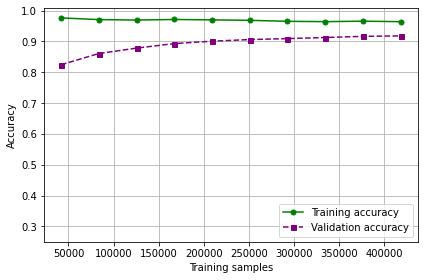

In [83]:
plot_learning_curve(dt, 'DecisionTree')

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0.82715518 0.82252964 0.82470257 0.82455197 0.8211097  0.82506831
  0.82237904 0.82358383 0.82358383 0.82674269]
 [0.86426712 0.86534283 0.8634711  0.86243842 0.86400895 0.86400895
  0.86411652 0.86549343 0.86306233 0.86673838]
 [0.88816936 0.88492072 0.88586734 0.88558766 0.88248962 0.88597491
  0.88646974 0.88715819 0.88433984 0.88788726]
 [0.90049698 0.89929218 0.90215357 0.8991631  0.90314322 0.90256234
  0.90232568 0.9011424  0.89991609 0.90243115]
 [0.91004927 0.91056561 0.91024289 0.91000624 0.91344851 0.91015684
  0.91058712 0.91000624 0.90905962 0.91179002]
 [0.91706289 0.91686926 0.91699834 0.91985973 0.91831071 0.91831071
  0.91777285 0.91609475 0.

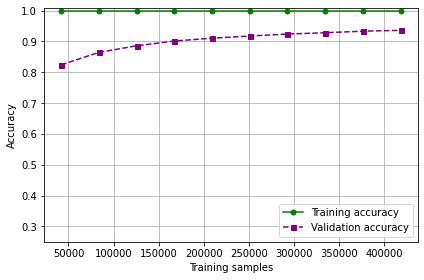

In [86]:
# Executes the Decision Tree classifier without setting any max depth, to highlight overfitting
dt = DecisionTreeClassifier()
plot_learning_curve(dt, 'DecisionTree-no_max_depth')

[[0.84991681 0.71102102 0.73488746 0.72895909 0.72886348 0.73020214
  0.72987703 0.72934157 0.72991528 0.72991528]
 [0.82953089 0.74279513 0.69334111 0.73594882 0.73601576 0.7366564
  0.73650341 0.73612094 0.73697195 0.73697195]
 [0.75694989 0.7262499  0.69293632 0.67311774 0.73929229 0.73973214
  0.7396174  0.73936879 0.73975126 0.73975126]
 [0.54609302 0.56406456 0.49575931 0.55569314 0.68023178 0.70305119
  0.70293645 0.70277868 0.70346714 0.70346714]
 [0.49271959 0.51901092 0.48209061 0.52575778 0.59746037 0.65479719
  0.55614542 0.55420627 0.55474173 0.55470731]
 [0.49957609 0.51462329 0.48759825 0.525884   0.51841936 0.56723273
  0.63998904 0.54787312 0.5499608  0.54964844]
 [0.47803911 0.46093428 0.4509189  0.4996025  0.51918522 0.49735136
  0.61754686 0.52615992 0.52625008 0.52477482]
 [0.47572718 0.45012526 0.44419451 0.4778284  0.47521323 0.5027084
  0.57027022 0.54862452 0.50154424 0.50473791]
 [0.49534337 0.45263366 0.45873838 0.48388187 0.49020758 0.51241025
  0.58549272 0

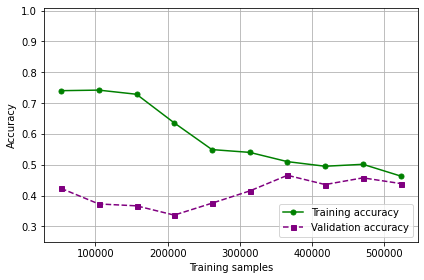

In [87]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=GaussianNB(), 
    X=x, y=y, 
    train_sizes=np.linspace(0.1,1,10), 
    cv=10, n_jobs=-1)

print(train_scores)
print(test_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='green', marker='o',
         markersize=5,label ='Training accuracy')

plt.plot(train_sizes, test_mean,
         color='purple', linestyle='--',
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.grid()
plt.xlabel('Training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.25, 1.01])
plt.tight_layout()
plt.savefig('NaiveBayes' + '-mean.png', dpi=300)
plt.show()